### Project Notebook
Matthew Robichaud

In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/gdrive')

# Location of Zip File
drive_path = '/content/gdrive/MyDrive/UW/ML-Data/HeLaTrainW.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
if not os.path.exists(local_path + '/HeLaTrain'):
    !cp '{drive_path}' .
    # Navigate to the copied file and unzip it quietly
    !unzip -q '/content/HeLaTrainW.zip'

sys.path.insert(0,'/content/gdrive/MyDrive/UW/ML-Data/harmonic')
sys.path.insert(0,'/content/gdrive/MyDrive/UW/ML-Data/')

from harmonic import * 
import loader

Mounted at /content/gdrive


In [ ]:
from embeddings import Embedding as Emb1
from sq_embeddings import Embedding as Emb2
from sinconv import AddHSine,AddSine
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.utils.data as data 

Hela = loader.hela('HeLaTrain/')

## Optimize Embedding
### Sine

In [ ]:
train_data = loader.Reader(Hela.rgb, Hela.labels, Hela.edges, Hela.transform, Hela.transform_target)
sampler = data.RandomSampler(train_data, replacement=True, num_samples=100)

gt_labels = torch.stack([Hela.transform_target(Image.open(lab).convert('L')).squeeze(0) for lab in Hela.labels])

def flat_pattern_rdm(num1, num2, variance):
    alpha = (torch.rand(num1) - 0.5) * variance
    phase = torch.rand(num1)*variance
    square = torch.rand(num1)
    sins1 = [AddSine(a, 0, ph) for a, ph in zip(alpha, phase)]
    sins1s = [AddHSine(a, 0, ph, s) for a, ph, s in zip(alpha, phase,square)]

    alpha = (torch.rand(num2) - 0.5) * variance
    phase = torch.rand(num2)*variance
    square = torch.rand(num2)
    sins2 = [AddSine(0, a, ph) for a, ph in zip(alpha, phase)]
    sins2s = [AddHSine(0, a, ph, s) for a, ph, s in zip(alpha, phase, square)]

    return torch.nn.Sequential(*(sins1 + sins2)),torch.nn.Sequential(*(sins1s + sins2s))

flatsine,flatsquare = flat_pattern_rdm(6,6,50)

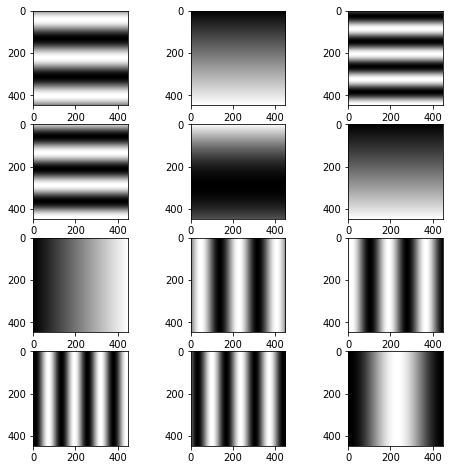

In [ ]:
sns = np.array([flatsine[i].generate_xy(torch.ones([1,1,448,448])).detach().numpy()[0][0] for i in range(len(flatsine))])
plt.figure(figsize=[8,8])
for i in range(0,sns.shape[0]):
    plt.subplot(4,3,i+1)
    plt.imshow(sns[i],cmap='gray')

In [ ]:
emb_gen = data.DataLoader(train_data, batch_size = 4, sampler = sampler, num_workers=2)
emb1 = Emb1(flatsine,[448,448])
val1 = []
err1 = []

In [ ]:
emb1.validate(gt_labels.float(),epsilon=2).item()

1.0204081535339355

In [ ]:
%%time 
for e in range(20):
    print('new epoch')
    for x,y,z in emb_gen: 
        s, e = emb1.fit(y.squeeze(1),niter=30,lr=50,epsilon=2)
        err1.append(e)
        val1.append(emb1.validate(gt_labels.float(),epsilon=2).item())
        print(str(err1[-1][0]) + ', ' + str(val1[-1]))

new epoch
[0.032617922872304916], 0.12244898080825806
[0.04564034938812256], 0.16326530277729034
[0.010805608704686165], 0.040816325694322586
[0.0029543954879045486], 0.040816325694322586
[0.013353814370930195], 0.020408162847161293
[0.0], 0.020408162847161293
[0.015167192555963993], 0.0
[0.0], 0.0


KeyboardInterrupt: ignored

In [ ]:
s

[[-7.375255107879639, 5.203563690185547, 45.27313232421875],
 [-7.378573417663574, -1.9893327951431274, 20.848262786865234],
 [-7.0850653648376465, -2.456326961517334, 41.53719711303711],
 [11.45650577545166, -2.489238739013672, 31.25278091430664],
 [-1.703177571296692, -6.168859958648682, 5.964511394500732],
 [11.166621208190918, 5.2173919677734375, 38.755393981933594],
 [-0.6013728380203247, 12.734735488891602, 3.7188491821289062],
 [6.044683933258057, 12.558919906616211, 52.94304656982422],
 [5.92817497253418, -0.7977170944213867, 54.80228805541992],
 [-0.38155657052993774, 23.551265716552734, 35.34095001220703],
 [1.972337245941162, 5.383609294891357, 46.41643524169922],
 [4.012279033660889, -4.179959774017334, 35.26789093017578]]

In [ ]:
sine_loss = np.array([item for items in err1 for item in items])

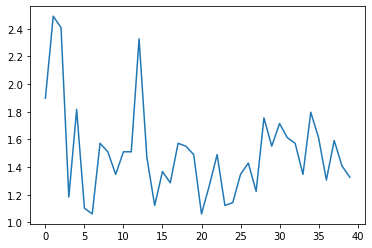

In [ ]:
plt.plot(val1)

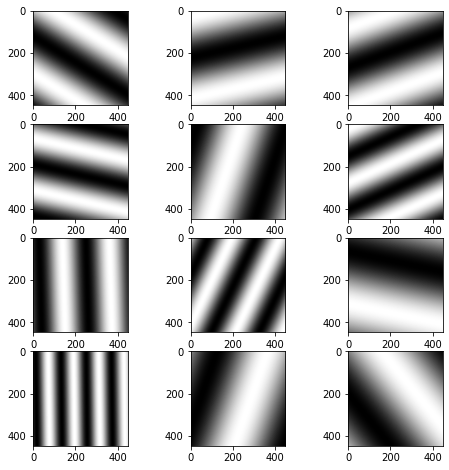

In [ ]:
from matplotlib import pyplot as plt
from google.colab import files
sns = np.array([emb1.sins[i].generate_xy(torch.ones([1,1,448,448])).detach().numpy()[0][0] for i in range(len(emb1.sins))])
plt.figure(figsize=[8,8])
for i in range(0,sns.shape[0]):
    plt.subplot(4,3,i+1)
    plt.imshow(sns[i],cmap='gray')
plt.savefig('sqsines.png',format='png')

### Square 

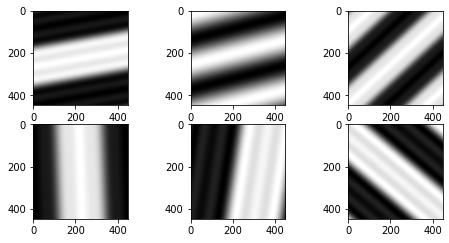

In [ ]:
sns = np.array([flatsquare[i].generate_xy(torch.ones([1,1,448,448])).detach().numpy()[0][0] for i in range(len(flatsquare))])
plt.figure(figsize=[8,8])
for i in range(0,sns.shape[0]):
    plt.subplot(4,3,i+1)
    plt.imshow(sns[i],cmap='gray')

In [ ]:
emb2 = Emb2(flatsquare,[448,448])
val2 = []
err2 = []

In [ ]:
emb2.validate(gt_labels.float(),epsilon=2).item()

3.326530694961548

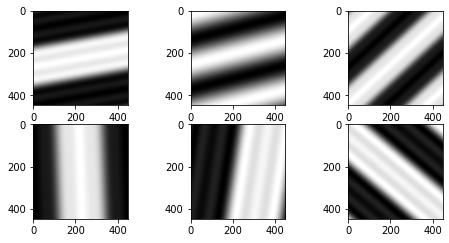

In [ ]:
from matplotlib import pyplot as plt
from google.colab import files
sns = np.array([emb2.sins[i].generate_xy(torch.ones([1,1,448,448])).detach().numpy()[0][0] for i in range(len(emb2.sins))])
plt.figure(figsize=[8,8])
for i in range(0,sns.shape[0]):
    plt.subplot(4,3,i+1)
    plt.imshow(sns[i],cmap='gray')
plt.savefig('sqsines.png',format='png')

# Training

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sins = [[-7.375255107879639, 5.203563690185547, 45.27313232421875],
 [-7.378573417663574, -1.9893327951431274, 20.848262786865234],
 [-7.0850653648376465, -2.456326961517334, 41.53719711303711],
 [11.45650577545166, -2.489238739013672, 31.25278091430664],
 [-1.703177571296692, -6.168859958648682, 5.964511394500732],
 [11.166621208190918, 5.2173919677734375, 38.755393981933594],
 [-0.6013728380203247, 12.734735488891602, 3.7188491821289062],
 [6.044683933258057, 12.558919906616211, 52.94304656982422],
 [5.92817497253418, -0.7977170944213867, 54.80228805541992],
 [-0.38155657052993774, 23.551265716552734, 35.34095001220703],
 [1.972337245941162, 5.383609294891357, 46.41643524169922],
 [4.012279033660889, -4.179959774017334, 35.26789093017578]]

npsins = np.array(sins)
guides = loader.guide_function(npsins[:,0],npsins[:,1],npsins[:,2],448,448)


In [ ]:
guides.shape

torch.Size([12, 448, 448])

### Square embedding

In [ ]:
from sq_embeddings import Embedding as Embsquare

sins = [[-13.559544563293457,
  -2.203810453414917,
  21.30968475341797,
  0.9219708442687988],
 [-22.703413009643555,
  -0.37252742052078247,
  10.278214454650879,
  0.999194860458374],
 [6.941484451293945,
  -2.721510410308838,
  44.56106948852539,
  0.9472301602363586],
 [7.547652721405029, 0.9692023992538452, 39.369895935058594, 1.0],
 [-14.903787612915039,
  -1.0364874601364136,
  4.260854721069336,
  0.9993869066238403],
 [-2.7566463947296143,
  4.760617256164551,
  5.812931060791016,
  0.9590798020362854],
 [1.0290216207504272, 5.537593841552734, 15.82655143737793, 1.0],
 [-0.4228498339653015,
  -12.698473930358887,
  8.141501426696777,
  0.9982108473777771],
 [0.3880113661289215, -13.395278930664062, 4.083737373352051, 1.0],
 [6.361560344696045, -6.721468925476074, 47.4748649597168, 0.4803535044193268],
 [-0.31598857045173645,
  24.429262161254883,
  22.79106903076172,
  0.9727568030357361],
 [3.190713405609131, 5.624609470367432, 21.73563003540039, 0.9920406937599182]]

emb2 = Embsquare(sins,[448, 448])
input = torch.zeros(1,1,448,448)

guides = []
for i in range(12):
    guides.append(emb2.sins[i].generate_xy(input).detach().squeeze(0).squeeze(0).numpy())
guides = torch.tensor(np.array(guides))

### Load Model

In [ ]:
from harmonic.embeddings import *
#from harmonic.sq_unet import UNet
from harmonic.unet import aUNet as UNet
from torch.utils.data import DataLoader
errors = []

train_data = loader.Reader(Hela.rgb, Hela.labels, Hela.edges, 
                           Hela.transform, Hela.transform_target, 
                           loader=loader.gray_loader)
generator = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)

unet = UNet(1, sins).to(device)
optim = torch.optim.Adam(unet.parameters(),lr=1e-5,weight_decay=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

In [ ]:
pytorch_total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
pytorch_total_params

30332848

##Pretrained backbone

In [ ]:
from harmonic.embeddings import *
from harmonic.unet import bUNet
from torch.utils.data import DataLoader

train_data = loader.Reader(Hela.rgb, Hela.labels, Hela.edges, Hela.transform, Hela.transform_target)
generator = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=1)

unet = bUNet(3, sins).to(device)
optim = torch.optim.Adam(unet.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

### Freeze the encoder 

In [ ]:
unet.backbone.requires_grad_(False)
pytorch_total_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
pytorch_total_params

AttributeError: ignored

## Optional PreTraining

### CVPPP

In [ ]:
from os.path import join
modelpath = '/content/gdrive/MyDrive/UW/ML-Data/'
caption = join(modelpath,"cvppp")
if os.path.exists(caption + '_ckp3.t7'):
    data = torch.load(caption + '_ckp3.t7')
    #unet.load_state_dict(data['model_state_dict'])
    #optim.load_state_dict(data['optimizer_state_dict'])
    #epoch = data['epoch']
else:
    print('no PT')

trained_dict = data['model_state_dict']
# Using items() + list comprehension
# Substring Key match in dictionary
res = dict(filter(lambda item: 'module.down' not in item[0], trained_dict.items()))
res = dict(filter(lambda item: 'module.outc' not in item[0], res.items()))
res = dict(filter(lambda item: 'module.inc' not in item[0], res.items()))
unet.load_state_dict(res,strict=False)

RuntimeError: ignored

### Hela (CV init) 

In [ ]:
from os.path import join

# HELA PRETRAIN FROM CVINIT
modelpath = '/content/gdrive/MyDrive/UW/ML-Data/'
caption = join(modelpath,"hela")
if os.path.exists(caption + '_cvinit_ckp.t7'):
    data = torch.load(caption + '_cvinit_ckp.t7')
    #unet.load_state_dict(data['model_state_dict'])
    #optim.load_state_dict(data['optimizer_state_dict'])
    #epoch = data['epoch']
else:
    print('no PT')

trained_dict = data['model_state_dict']
# Using items() + list comprehension
# Substring Key match in dictionary
res = dict(filter(lambda item: 'module.up' not in item[0], trained_dict.items()))
res = dict(filter(lambda item: 'module.out' not in item[0], res.items()))

res2 = {}
for key in res.keys():
    new_key = key[7:]
    res2[new_key] = res[key]

unet.load_state_dict(res2,strict=False)



_IncompatibleKeys(missing_keys=['up1.sinconv.addcoords.0.alpha', 'up1.sinconv.addcoords.0.beta', 'up1.sinconv.addcoords.0.phase', 'up1.sinconv.addcoords.1.alpha', 'up1.sinconv.addcoords.1.beta', 'up1.sinconv.addcoords.1.phase', 'up1.sinconv.addcoords.2.alpha', 'up1.sinconv.addcoords.2.beta', 'up1.sinconv.addcoords.2.phase', 'up1.sinconv.addcoords.3.alpha', 'up1.sinconv.addcoords.3.beta', 'up1.sinconv.addcoords.3.phase', 'up1.sinconv.addcoords.4.alpha', 'up1.sinconv.addcoords.4.beta', 'up1.sinconv.addcoords.4.phase', 'up1.sinconv.addcoords.5.alpha', 'up1.sinconv.addcoords.5.beta', 'up1.sinconv.addcoords.5.phase', 'up1.sinconv.addcoords.6.alpha', 'up1.sinconv.addcoords.6.beta', 'up1.sinconv.addcoords.6.phase', 'up1.sinconv.addcoords.7.alpha', 'up1.sinconv.addcoords.7.beta', 'up1.sinconv.addcoords.7.phase', 'up1.sinconv.addcoords.8.alpha', 'up1.sinconv.addcoords.8.beta', 'up1.sinconv.addcoords.8.phase', 'up1.sinconv.addcoords.9.alpha', 'up1.sinconv.addcoords.9.beta', 'up1.sinconv.addcoord

## Training routine

In [ ]:
from os.path import join

modelpath = '/content/gdrive/MyDrive/UW/ML-Data/'
caption = join(modelpath,"hela")
if os.path.exists(caption + '_base0_ckp0.t7'):
    data = torch.load(caption + '_base0_ckp0.t7')
    unet.load_state_dict(data['model_state_dict'])
    optim.load_state_dict(data['optimizer_state_dict'])
    epoch = data['epoch']
    errors = data['error']
else:
    print('no PT')
    epoch = 0

#epoch=0

#unet.backbone.requires_grad_(True)
for e in range(epoch,4000):
    epoch = e
    for x,y,z in generator:
        optim.zero_grad()
        y_grad, weight =embedder(y.squeeze(1).to(device))
        y_pred =unet(x.to(device))
        z = z.to(device).float()
        loss = torch.nn.functional.l1_loss(y_pred,y_grad, reduce=False)
        #edge_loss = torch.mean(torch.mean(loss, dim=1)*z)
        loss = torch.mean((weight.detach() * torch.mean(loss, dim=1)))#+10.*edge_loss
        loss.backward()
        errors+=[loss.item()]
        optim.step()
      
    print(np.log(loss.item()))
    if (e%100 == 0):
        torch.save({
                'epoch': e,
                'model_state_dict': unet.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'loss': loss,
                'error': errors
            }, caption + '_base0_ckp0.t7')

plt.plot(errors)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


-2.590671923150771
-2.595759749885819
-2.6131254992180706
-2.662072960559921
-2.60703422216141
-2.607829268560191
-2.570318672458855
-2.5528615301310076
-2.5971822703775707
-2.6296281977771847
-2.6890820038253063
-2.565941342779838
-2.5691046066461514
-2.616953694674709
-2.604602781885175
-2.5834692279264
-2.5929359053210304
-2.5881086891820737
-2.6350769956737676
-2.6277138942506446
-2.584295420711429
-2.5496757005777653
-2.634336611122925
-2.6751079096854276
-2.6231469456579357
-2.7230443499333568
-2.6017382148062
-2.5107643831688633
-2.6318079248896837
-2.5597407371087018
-2.6827588225391965
-2.723362392617638
-2.442674460027656
-2.6680714790017044
-2.6942537052317017
-2.622469197655923
-2.666561262328826
-2.6136903594383223
-2.6010875710432417
-2.5029719384450964
-2.6431655430615577
-2.5355594433278954
-2.5384309357205272
-2.5052398681668215
-2.581735949260201
-2.6691987332398415
-2.5819636021524865
-2.638744930868916
-2.51453180284302
-2.561207072483924
-2.5887350698217406
-2.5064

In [ ]:
import matplotlib.pyplot as plt
torch.save({
                'error': errors}, caption + '_square_loss.t7')

In [ ]:
# Helo

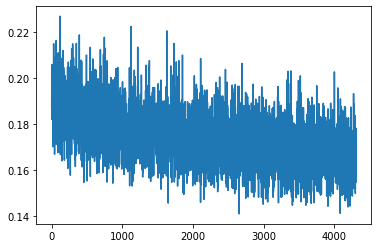

In [ ]:
plt.plot(errors)